# Testing the ability to distinguish signal events from background

In [1]:
%pylab inline
import sys
sys.path.insert(0, '../modules')

Populating the interactive namespace from numpy and matplotlib


In [2]:
from hits import AllHits
hits = AllHits('../data/signal_TDR.root')

In [3]:
figsize(8,8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

### Record (Raw) Wire Features 

In [4]:
right_neighs = numpy.array([hits.cydet.shift_wire(wire, 1) for wire in range(hits.cydet.n_points)])
left_neighs = numpy.array([hits.cydet.shift_wire(wire, -1) for wire in range(hits.cydet.n_points)])

In [5]:
# Energy deposits
deposits = numpy.vstack(hits.get_energy_deposits(i) for i in range(hits.n_events))
deposits *= 100 # to avoid small numbers for GBRT
# Time after triggering that signal waveforms starts
rel_time = numpy.vstack(hits.get_relative_time(i) for i in range(hits.n_events))
# Truth Values
labels = numpy.vstack(hits.get_hit_types(i) for i in range(hits.n_events))
# Signal like or not (apriori)
#sig_like = numpy.vstack(hits.get_prob_sig_wire(i) for i in range(hits.n_events))
# Layer ID of hit wires
layer_id = numpy.vstack(hits.cydet.point_rhos for i in range(hits.n_events))

In [6]:
labels.shape, deposits.shape

((3445, 4482), (3445, 4482))

## Prepare Neighbour Features

In [7]:
from collections import OrderedDict
features = OrderedDict()
# Wire features
features['deposit'] = deposits * 100
features['rel_time'] = rel_time
features['layer_id'] = layer_id

# LR-Neighbour Features
features['r_deposit'] = (deposits * 100)[:, right_neighs]
features['r_rel_time'] = rel_time[:, right_neighs]
features['l_deposit'] = (deposits * 100)[:, left_neighs]
features['l_rel_time'] = rel_time[:, left_neighs]

# Truth values
features['labels'] = labels
features['double_labels'] =  numpy.take([0, 1, 0], labels)

## Train/test splitting 

In [ ]:
# bad event 2192
# good event 1
# good two peak 882

In [8]:
from sklearn.cross_validation import train_test_split
rest, sample_3 = train_test_split(range(len(labels)), train_size=0.6, test_size=0.3)
sample_1, sample_2 = train_test_split(rest, train_size=0.5, test_size=0.5)
sample_3.append(1)

In [9]:
# TODO propragate this through
event_to_hit_look = np.arange(hits.n_events*hits.cydet.n_points).reshape(hits.n_events, -1)

## Label all features for Pandas data frame

In [10]:
def flatten_data(data, keys, samples, n_features):
    data_flat = data[samples].reshape(-1, n_feats)
    return pandas.DataFrame(data=data_flat, columns=keys)
def double_labels_only(data):
    # Purge cells with no hits out
    data = data[data['labels'] != 0]
    # Define signal hit as 1, background hit as 0
    data['labels'] = 2 - data['labels']
    return data
def mask(data, pol=None):
    if pol==None:
        return data[data['labels'] != 0]
    if pol==0:
        return data[(data['labels'] == 0) & (data['Polarity'] == 0)]
    if pol==1:
        return data[(data['labels'] != 0) & (data['Polarity'] != 0)]

In [11]:
# Name train features as all featurs except labels, and double labels
train_features = features.keys()[:-2]

In [12]:
# Name data as all features stacked in 3D array
data = numpy.dstack(features.values())

In [13]:
import pandas
# Count the number of features
data.shape
n_feats = data.shape[-1]

In [14]:
np.append(sample_3, 1)

array([2685,  156, 2127, ...,  527,    1,    1])

In [15]:
data_1, data_2, data_3 = [flatten_data(data, features.keys(), samp, n_feats) 
                          for samp in [sample_1, sample_2, sample_3]]

## Build the Classifiers

In [16]:
from rep.metaml.factory import ClassifiersFactory
from rep.estimators import SklearnClassifier
from sklearn.ensemble import GradientBoostingClassifier
from rep.report.metrics import RocAuc

In [17]:
factory = ClassifiersFactory()

# Define GBDT over wire features
neigh_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100, warm_start=True), 
                                    features=train_features)

# Define GBDT over only energy deposit to compare
dep_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100, warm_start=True), 
                               features=['deposit'])
factory.add_classifier('Energy Deposit', dep_gbdt)
factory.add_classifier('Local and Neighbour Features', neigh_gbdt)

In [18]:
# Train the classifier
factory.fit(mask(data_1), mask(data_1)['double_labels'])
pass

model Energy Deposit was trained in 37.70 seconds
model Local and Neighbour Features was trained in 148.43 seconds
Totally spent 186.14 seconds on training


In [19]:
# Test the classifier
pred_2 = factory.test_on(mask(data_2), mask(data_2)['double_labels'])

/home/elg112/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family [u'normal'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


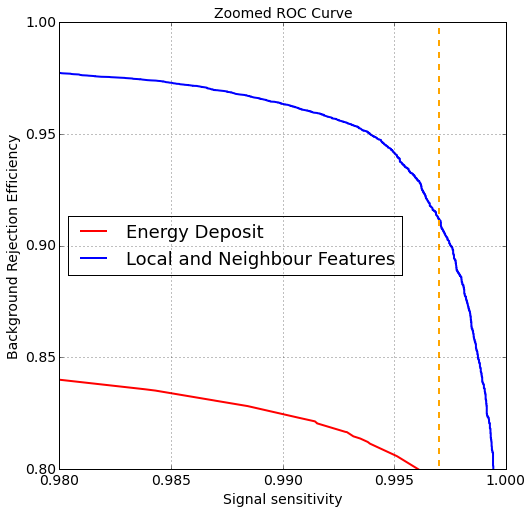

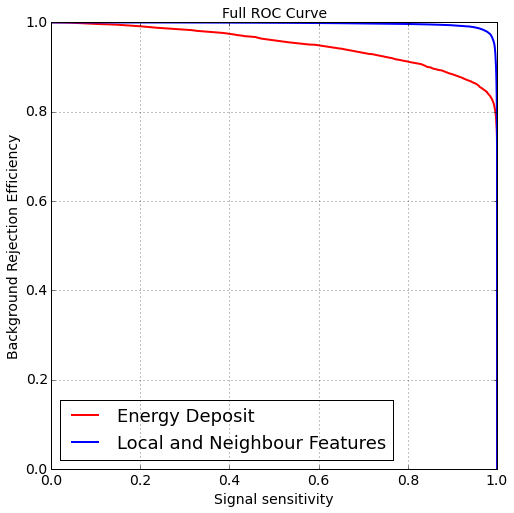

In [20]:
roc = pred_2.roc()
roc.title = "Zoomed ROC Curve"
roc.ylabel = "Background Rejection Efficiency"
roc.plot(xlim=[0.98,1.], ylim=[0.80,1.], figsize=(12,8))
plt.plot([.997, .997], [0.75, 1.], 'k--', lw=2,c='orange')
show()
roc.title = "Full ROC Curve"
roc.plot()


### Measure Effectiveness of GBDT

In [21]:
#n_bins = 10
#bin_width = 1./n_bins
#p = predictions.prediction['All Features'][:, 1]
#fpr, tpr, thresholds = roc_curve(test_data['labels'], p)
#signal_weight = 

#limits = numpy.percentile(p, [10, 20, 30, 40, 50, 60, 70, 80, 90])
#bin_indices = numpy.searchsorted(limits, p)
#s = numpy.bincount(bin_indices, weight=signal_weight)
#b = numpy.bincount(bin_indices, weight=bck_weight)
#result = numpy.sum(s * s / (b + regularization))

# Perform the Hough Transform

In [22]:
from tracking import Hough
from sklearn.preprocessing import normalize
from scipy.sparse import vstack
from sklearn.metrics import roc_auc_score, roc_curve

hough = Hough(hits,rho_bins=20, sig_rho_min=31.5, sig_rho=34, sig_rho_max=34.5, sig_rho_sgma=2)

In [23]:
wire_rhos, wire_phis = hits.cydet.get_points_rhos_and_phis()
wire_xs, wire_ys = hits.cydet.get_points_xs_and_ys()
track_rhos, track_phis = hough.track.get_points_rhos_and_phis()
track_xs, track_ys = hough.track.get_points_xs_and_ys()

In [24]:
# Define even and odd layer wires
even_wires = hits.cydet.point_pol != 1
odd_wires = hits.cydet.point_pol == 1

corresp = hough.correspondence.T
    
# Make even and odd layer hough matricies
corresp_even = corresp.copy()
corresp_even[:, odd_wires] = 0
corresp_odd = corresp.copy()
corresp_odd[:, even_wires] = 0

# Define inverses
corresp_even_inv = corresp_even.T.copy()
corresp_odd_inv = corresp_odd.T.copy()

# Normalize
corresp_even = normalize(corresp_even, norm='l1', axis=1)
corresp_odd = normalize(corresp_odd, norm='l1', axis=1)

def prepare_hough(wire_probabilities, alpha=2.):
    """
    Alpha defines scaling of expontent in reweighting procedure
    """
    # Apply the forward hough transforms to all events 
    # This defines the probability of a track center
    #hough_out = hough_forward.dot(wire_probabilities.T).T
    hough_even = corresp_even.dot(wire_probabilities.T).T
    hough_odd = corresp_odd.dot(wire_probabilities.T).T
    
    # TODO: normalize in hough space on even odd, then reweight, then invert, then combine?
    
    # Probability due to fitting even and odd must be reweighted first
    hough_even = numpy.exp(alpha * hough_even.T)
    hough_odd = numpy.exp(alpha * hough_odd.T)    
    
    # Now we can combine the two
    #hough_both = hough_even + hough_odd
    
    # Apply the inverse hough transform to the exponentiated hough transform out put
    # This weights track points closer to the tracks as more likely
    hough_even_inv = corresp_even_inv.dot(hough_even).T
    hough_odd_inv = corresp_odd_inv.dot(hough_odd).T
    
    return hough_even_inv, hough_odd_inv, hough_even.T, hough_odd.T

In [25]:
def norm_comb_hough(hough_even_pred, hough_odd_pred, normalize=True):
    hough_even_pred = hough_even_pred.flatten()
    hough_odd_pred = hough_odd_pred.flatten()

    if normalize:
        hough_predictions = hough_even_pred/np.amax(hough_even_pred) +\
                            hough_odd_pred/np.amax(hough_odd_pred)
    else: 
        hough_predictions = hough_even_pred + hough_odd_pred
    return hough_predictions

##Prepare the data

In [26]:
# Apply to the final training and testing data
neigh_out_2 = neigh_gbdt.predict_proba(data_2)[:,1]
neigh_out_3 = neigh_gbdt.predict_proba(data_3)[:,1]

# Randomize output of GBDT 
fake_2 = numpy.random.exponential(0.1 + neigh_out_2, size=neigh_out_2.shape)

# Set all wires with no hits to negative weight
unhit = (data_2['labels'] == 0).values
neigh_out_2[unhit] = 0
unhit = (data_3['labels'] == 0).values
neigh_out_3[unhit] = 0

### Randomize output of GBDT to test output of Hough

In [27]:
# Weight the hits missed by the GBDT as higher
problem_weights_2 = (data_2['labels'] != 0) * abs(data_2['double_labels'] - neigh_out_2) ** 2

print roc_auc_score(data_2['double_labels'], fake_2, sample_weight=data_2['labels'] != 0)
print roc_auc_score(data_2['double_labels'], fake_2, sample_weight=problem_weights_2)

0.886036419529
0.403268968435


In [28]:
# Reshape wires by event, i.e. reshape so that each event has cydent.n_points
neigh_out_2 = neigh_out_2.reshape(-1,hits.cydet.n_points)
neigh_out_3 = neigh_out_3.reshape(-1,hits.cydet.n_points)
fake_2 = fake_2.reshape(-1,hits.cydet.n_points)

### Preform Parameter Scan over Alpha

In [29]:
alpha_min = 5.0
alpha_max = 15.0
n_alphas = 20
d_alpha = (alpha_max - alpha_min)/n_alphas
alphas, tpr_hough,  fpr_hough = np.zeros(n_alphas), np.zeros(n_alphas), np.zeros(n_alphas) 

for this_alpha in range(n_alphas):
    alpha_try = alpha_min + d_alpha*this_alpha
    # generating fake predictions based on gbdt. Probably there is more appropriate distibution

    hough_even_pred, hough_odd_pred, _ , _ = prepare_hough(fake_2, alpha_try)
    hough_predictions = norm_comb_hough(hough_even_pred, hough_odd_pred)
    
    tpr_hough[this_alpha] = roc_auc_score(data_2['double_labels'], hough_predictions,\
                                          sample_weight=problem_weights_2)
    alphas[this_alpha] = alpha_try
    #print alpha_try, tpr_hough[this_alpha], " "

In [30]:
print alphas[ where(tpr_hough == max(tpr_hough)) ]
best_alpha = alphas[ np.where(tpr_hough == max(tpr_hough))]
print alphas
print tpr_hough

[ 10.5]
[  5.    5.5   6.    6.5   7.    7.5   8.    8.5   9.    9.5  10.   10.5
  11.   11.5  12.   12.5  13.   13.5  14.   14.5]
[ 0.57801302  0.5800552   0.58174726  0.58310533  0.5842171   0.58514076
  0.58592022  0.58660148  0.58708642  0.58731968  0.5875596   0.58765627
  0.58740917  0.58702678  0.58547911  0.58461523  0.58321345  0.58188811
  0.58043051  0.57704059]


## Comparing the quality of inital quess vs after the Hough transform

In [31]:
alpha_try = best_alpha

hough_even_pred, hough_odd_pred, _ , _ = prepare_hough(fake_2, alpha_try)
hough_predictions = norm_comb_hough(hough_even_pred, hough_odd_pred)

fake_2 = fake_2.flatten()

print roc_auc_score(data_2['double_labels'], fake_2, sample_weight=data_2['labels'] != 0)
print roc_auc_score(data_2['double_labels'], hough_predictions, sample_weight=problem_weights_2)

0.886036419529
0.587656267236


### Observe effect of re-weighting in hough space

In [33]:
fig = plt.figure()
ax_1 = fig.add_subplot(221)
ax_2 = fig.add_subplot(222)

hough_out = corresp.dot(neigh_out_2.T).T
ax_1.hist(hough_out.flatten(), log=True)
plt.xlabel('hough on track')
plt.ylabel('number of tracks')

alpha_try = best_alpha
# if we use alpha=alpha_try, then contribution will look ole this: 
ax_2.hist(hough_out.flatten(), log=True, weights=numpy.exp(alpha_try * hough_out.flatten()))
show()

ValueError: cannot convert float NaN to integer

# Hough Predictions vs. GBDT out

## Apply Hough to train and test data

In [34]:
#Perform the hough transform over these
final_alpha = best_alpha
polarity = numpy.vstack(hits.cydet.point_pol for i in range(hits.n_events))

# Add the flattened ouput as a feature
hough_even_2, hough_odd_2, hough_even_img_2 , hough_odd_img_2 = prepare_hough(neigh_out_2, final_alpha)
data_2['Hough'] = norm_comb_hough(hough_even_2, hough_odd_2, normalize=False)
data_2['Hough_Norm'] = norm_comb_hough(hough_even_2, hough_odd_2, normalize=True)
data_2['Hough_Odd'] = hough_odd_2.flatten()
data_2['Hough_Even'] = hough_even_2.flatten()
data_2['Polarity'] = polarity[sample_2, :].flatten()


# Add the flattened ouput as a feature
hough_even_3, hough_odd_3, hough_even_img_3 , hough_odd_img_3 = prepare_hough(neigh_out_3, final_alpha)
data_3['Hough'] = norm_comb_hough(hough_even_3, hough_odd_3, normalize=False)
data_3['Hough_Norm'] = norm_comb_hough(hough_even_3, hough_odd_3, normalize=True)
data_3['Hough_Odd'] = hough_odd_3.flatten()
data_3['Hough_Even'] = hough_even_3.flatten()
data_3['Polarity'] = polarity[sample_3].flatten()

## Define and add final GBDT to the factory list

In [35]:
# Define features to be used in final GBDT
hough_gbdt_f = train_features + ['Hough']
hough_norm_gbdt_f = train_features + ['Hough_Norm']
hough_even_gbdt_f = train_features + ['Hough_Even']
hough_odd_gbdt_f = train_features + ['Hough_Odd']

# Define GBDT over all features, including Hough
hough_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=hough_gbdt_f) 
#hough_gbdt_norm = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=hough_norm_gbdt_f) 
hough_even_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=hough_even_gbdt_f) 
hough_odd_gbdt = SklearnClassifier(GradientBoostingClassifier(n_estimators=100), features=hough_odd_gbdt_f) 

factory.add_classifier('Hough, Local and Neighbour Features', hough_gbdt)
#factory.add_classifier('Hough Norm', hough_gbdt_norm)

In [36]:
# Train the classifier
factory.fit(mask(data_2), mask(data_2)['double_labels'])
pass

model Energy Deposit was trained in 0.90 seconds
model Local and Neighbour Features was trained in 1.23 seconds
model Hough, Local and Neighbour Features was trained in 180.35 seconds
Totally spent 182.48 seconds on training


In [37]:
#%%time
#hough_odd_gbdt.fit(mask(data_3, pol==1), mask(data_3, pol==1)['double_labels'])
#hough_even_gbdt.fit(mask(data_3, pol==0), mask(data_3, pol==0)['double_labels'])

In [38]:
# Test the classifier
pred_final_3 = factory.test_on(mask(data_3), mask(data_3)['double_labels'])

In [39]:
#pred_final_even_3 = hough_odd_gbdt.predict_proba(mask(data_3, pol==1), mask(data_3, pol==1)['double_labels'])
#pred_final_odd_3 = hough_even_gbdt.predict_proba(mask(data_3, pol==0), mask(data_3, pol==0)['double_labels'])

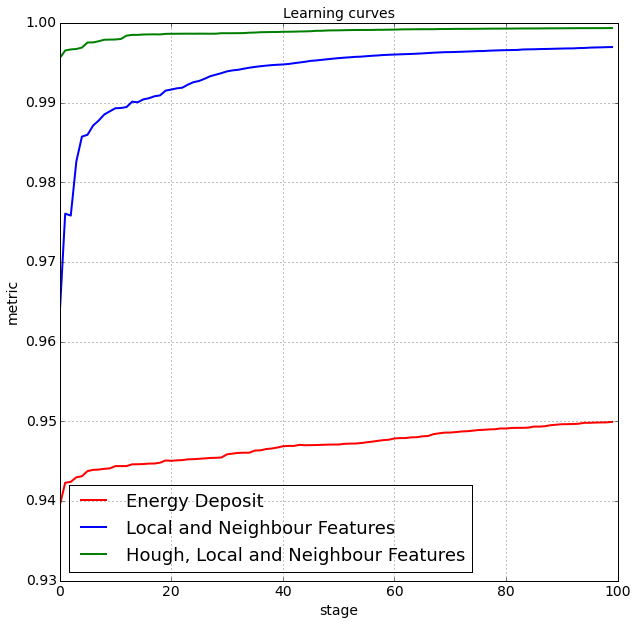

In [40]:
# Look at learning curves
figsize(10,10)
pred_final_3.learning_curve(RocAuc(), steps=1)

In [41]:
import matplotlib.ticker as mtick

In [42]:
def plot_rocs(labels, predictions, zoom=False):
    predicts = predictions.keys()
    fig = plt.figure(1)
    axs = [fig.add_subplot(111)]*len(predicts)

    for pred, ax in zip(predicts,axs):
        fpr, tpr, values =  roc_curve(labels, predictions[pred][:,1])
        fpr *= 100.
        tpr *= 100.
        ax.xaxis.tick_top()
        ax.set_xlabel('Signal Retention Efficiency', fontsize=15)
        ax.xaxis.set_label_position('top') 
        ax.set_ylabel('Background Rejection Efficiency', fontsize=15)    
        ax.plot(tpr, 100-fpr, label=pred)
        ax.grid(b=True, which='minor', color='grey', linestyle=':')
        ax.grid(b=True, which='major', color='grey', linestyle='--')
        
        
        fmt = '%.0f%%' # Format you want the ticks, e.g. '40%'
        xticks = mtick.FormatStrFormatter(fmt)
        ax.xaxis.set_major_formatter(xticks)
        ax.yaxis.set_major_formatter(xticks)
        
        ax.set_axisbelow(True)
        if zoom:
            ax.set_xlim([98,100])
            ax.set_ylim([70,100])
            ax.set_xticklabels(["98%","98.5%","99%","99.5%","100%"])
        ax.minorticks_on()
        leg = ax.legend(loc=0, frameon=1, fontsize=15)
    frame = leg.get_frame()
    frame.set_facecolor('white')

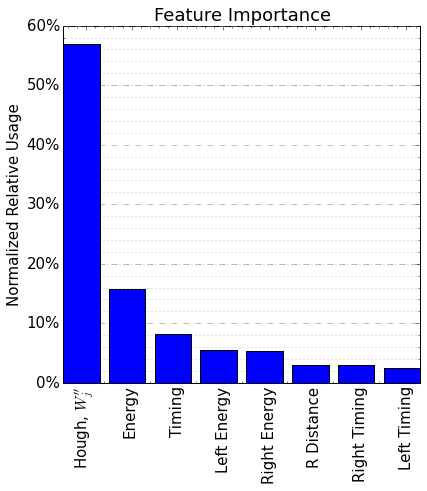

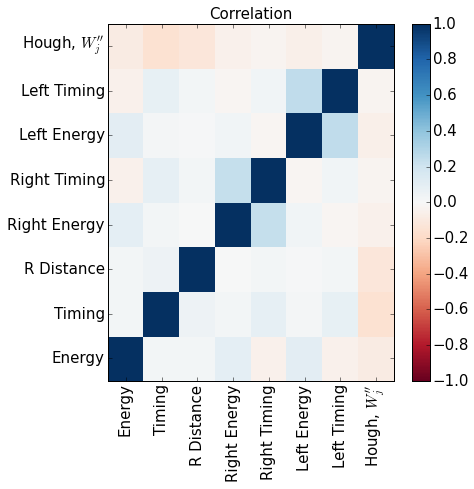

In [173]:
figsize(6.4,6.4) 
hough_level = factory["Hough, Local and Neighbour Features"]
feat_import = hough_level.get_feature_importances()
feat_import = feat_import.sort("effect", ascending=False)
feat_label_dict = OrderedDict([
        ('l_rel_time' , "Left Timing"),  
        ('r_rel_time' , "Right Timing"),
        ("layer_id" , "R Distance"), 
        ('r_deposit' , 'Right Energy'), 
        ('l_deposit' , 'Left Energy'), 
        ('rel_time' , "Timing"),
        ('deposit' , 'Energy'), 
        ('Hough' , r"Hough, $W_j''$")
    ])
ax = plt.subplot(111)
ax.bar( np.arange(len(feat_import.values)), feat_import.values,zorder=10)
ax.set_xticks(np.arange(len(feat_import.values))+0.5)
ax.minorticks_on()
ax.set_ylabel("Normalized Relative Usage")
ax.set_title("Feature Importance")
ax.autoscale()

ax.grid(b=True, which='major', axis='y' ,color='grey', linestyle='--')
ax.grid(b=True, which='minor', axis='y' , color='grey', linestyle=':')
ax.set_xticklabels(feat_label_dict.values()[::-1],  rotation='vertical')
ax.set_yticklabels(["0%","10%","20%","30%","40%","50%","60%"])
savefig(save_dir+"feat_import.png",bbox_inches='tight')

show()

corr = pred_final_3.features_correlation_matrix(features=train_features+["Hough"],
                            tick_labels=[feat_label_dict[key] for key in hough_gbdt_f])
corr.fontsize = 15
corr.cmap = "RdBu"
corr.plot()
#savefig(save_dir+"corr_matrix.png", bbox_inches='tight')

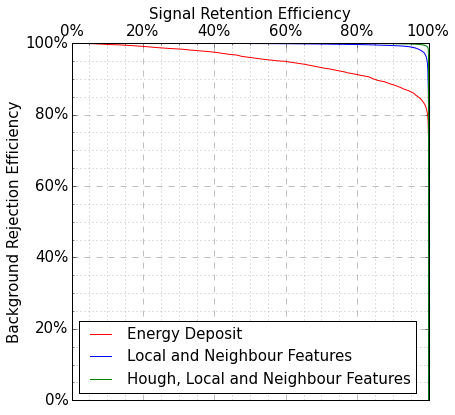

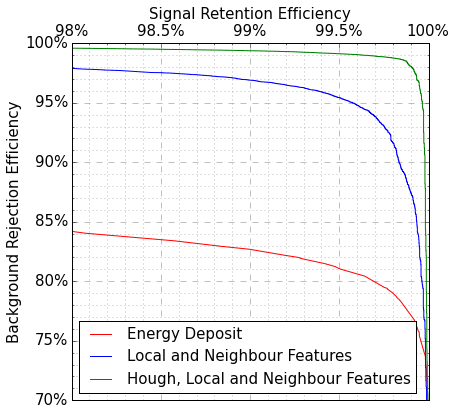

In [44]:
figsize(6.4,6.4) 
plot_rocs(mask(data_3)["double_labels"], pred_final_3.prediction, zoom=False)
#savefig(save_dir+"roc.png", bbox_inches='tight')
show()
plot_rocs(mask(data_3)["double_labels"], pred_final_3.prediction, zoom=True)
#savefig(save_dir+"roc_zoom.png", bbox_inches='tight')

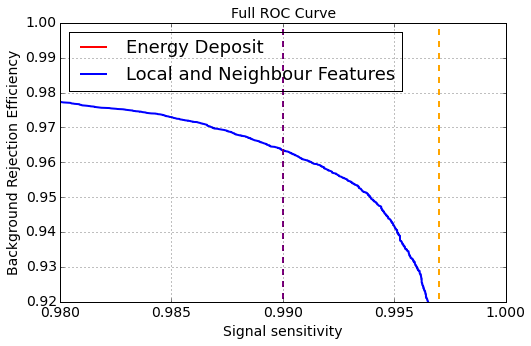

In [45]:
figsize(8,5)

roc.plot(xlim=[0.98,1.], ylim=[0.92,1.])
plt.plot([.99, .99], [0.75, 1.], 'k--', lw=2,  c='purple' )
plt.plot([.997, .997], [0.75, 1.], 'k--', lw=2,c='orange')


In [46]:
feat = pred_final_3.feature_importance()

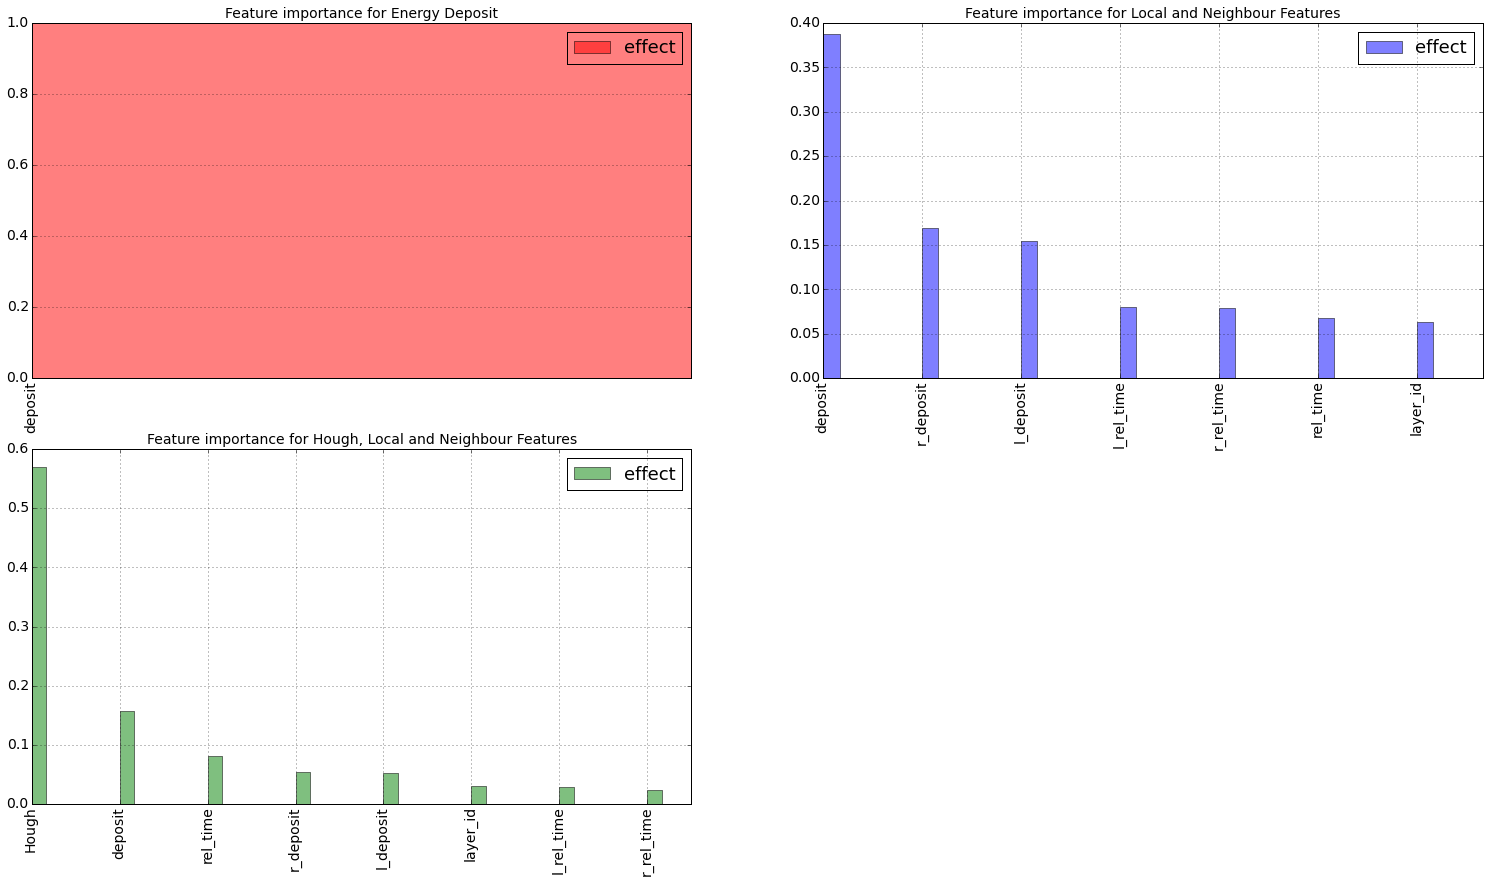

In [47]:
feat.plot(new_plot=True)

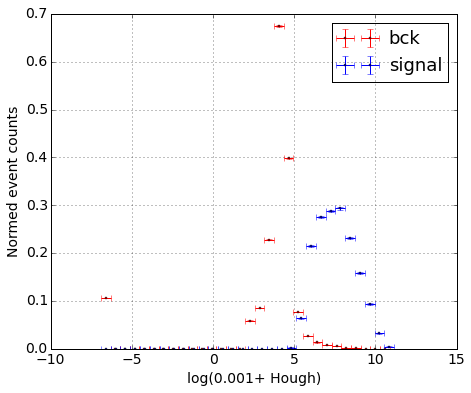

In [48]:
pred_final_3.features_pdf(features=['log(0.001+ Hough)'])

In [115]:
dot_size = 40
def setup_plot_for_detector(size=(15, 15)):
    figsize(*size)
    axes(polar=True)
    # set appropriate
    ylim(0, 85) 
def draw_output(signal_hits, background_hits, size=dot_size*np.ones(4482), 
                sig_color="blue", bkg_color="red"):
    setup_plot_for_detector(size=(12,14))
    thetaticks = np.arange(0,360,45)
    ax = plt.subplot(111, polar=True)
    ax.set_thetagrids(thetaticks, frac=1.05)
    ax.set_yticks(np.arange(10,81,20))
    ax.scatter(wire_phis, wire_rhos, marker='.', s=5, alpha=0.2)
    ax.scatter(wire_phis[signal_hits],wire_rhos[signal_hits], s=size[signal_hits], 
               marker='o', color=sig_color)
    ax.scatter(wire_phis[background_hits],wire_rhos[background_hits], marker='o', 
               color=bkg_color, s=size[background_hits])
    return ax

def add_outlines(signal_hits, background_hits, sig_color="blue", bkg_color="red", size=dot_size):
    plt.scatter(wire_phis[signal_hits],wire_rhos[signal_hits], s=size,
               marker='o', edgecolors=sig_color, facecolors='none',  lw = 0.5)
    plt.scatter(wire_phis[background_hits],wire_rhos[background_hits], s=size, 
               marker='o', edgecolors=bkg_color, facecolors='none',  lw = 0.5)

def add_tracks(track_cs, track_size, color="green"):
    plt.scatter(track_phis[track_cs] ,track_rhos[track_cs], s=track_size[track_cs], marker='o', color=color, zorder=10)     

def add_circle(x, y, radius, spread=0, color="green", line_w=1., spread_w=0.025):
    target_radius = plt.Circle((x, y), radius, transform=ax.transData._b, 
                               color=color, fill=False, alpha=line_w)
    gca().add_artist(target_radius)
    if spread!=0:
        target_spread = plt.Circle((x, y), radius, 
                                   transform=ax.transData._b, color="green", 
                                   alpha=spread_w, fill=False, lw=spread)
        gca().add_artist(target_spread) 
        
def add_transform(x, y, radius, r_max, r_min, color="green", line_w=1., spread_w=0.025):
    target_radius = plt.Circle((x, y), radius, transform=ax.transData._b, 
                               color=color, fill=False, alpha=line_w, lw=0.5)
    gca().add_artist(target_radius)
    for r in np.linspace(r_min, r_max, 10):
        target_spread = plt.Circle((x, y), r, 
                                   transform=ax.transData._b, color=color, 
                                   alpha=spread_w*hough.dist_prob(r)/hough.dist_prob(radius), 
                                   fill=False, lw=3)
        gca().add_artist(target_spread)
        
def norm_size(bdt_guess, size=dot_size):
    return (float(size)*bdt_guess)/np.amax(bdt_guess)

In [50]:
hough_orig = corresp.copy()
hough_orig = normalize(hough_orig, norm='l1', axis=1)
neigh_out_3 = neigh_gbdt.predict_proba(data_3)[:,1]
unhit = (data_3['labels'] == 0).values

neigh_out_3[unhit] = 0

neigh_out_3 = neigh_out_3.reshape(-1, hits.cydet.n_points)
hough_image_orig = hough_orig.dot(neigh_out_3.T).T
neigh_out_3 = neigh_out_3.flatten()

In [114]:
print sample_3[227]

882


In [169]:
event = 402
#event = 10
save_fig = True
save_dir = "/home/elg112/COMET/Presentations_Papers/9month_review/images/"

evt_hits = event_to_hit_look[event]

to_plot = data_3["labels"].values[evt_hits]

hough_out_3 = hough_gbdt.predict_proba(data_3)[:,1]
unhit = (data_3['labels'] == 0).values
hough_out_3[unhit] = 0

hough_image_cut = 0.0001

hough_image = hough_even_img_3[event] + hough_odd_img_3[event]
draw_tracks = np.where(hough_image > np.amax(hough_image)*hough_image_cut )[0]

hough_image_evt = hough_image_orig[event].flatten()
draw_tracks_orig = np.where(hough_image_evt > np.amax(hough_image_evt)*hough_image_cut )[0]

sig = np.where(to_plot == 1)[0]
bkg =  np.where(to_plot == 2)[0]

first_gbdt = neigh_out_3[evt_hits]
draw_points = np.where(first_gbdt > np.amax(first_gbdt)*hough_image_cut )[0]

second_gbdt = hough_out_3[evt_hits]

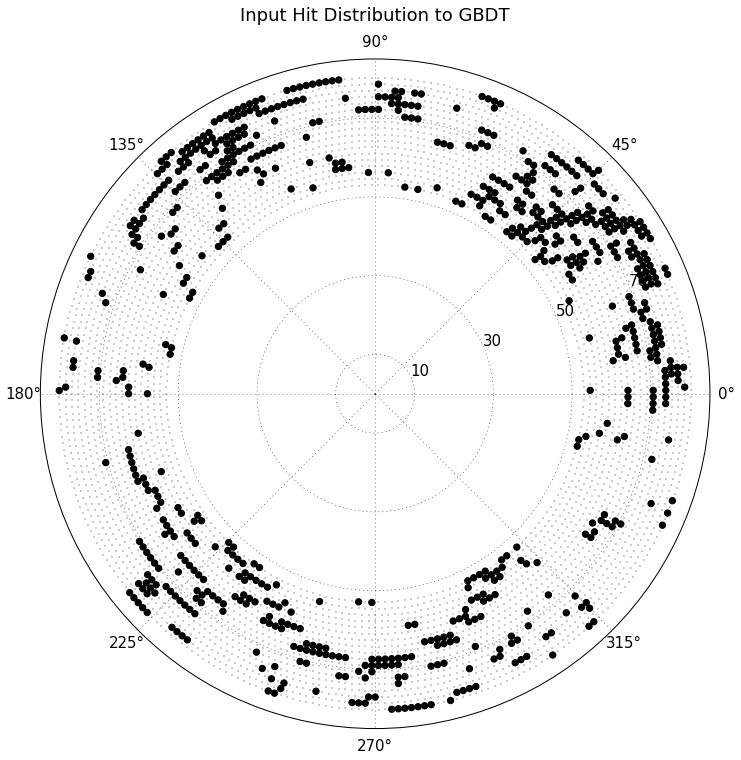

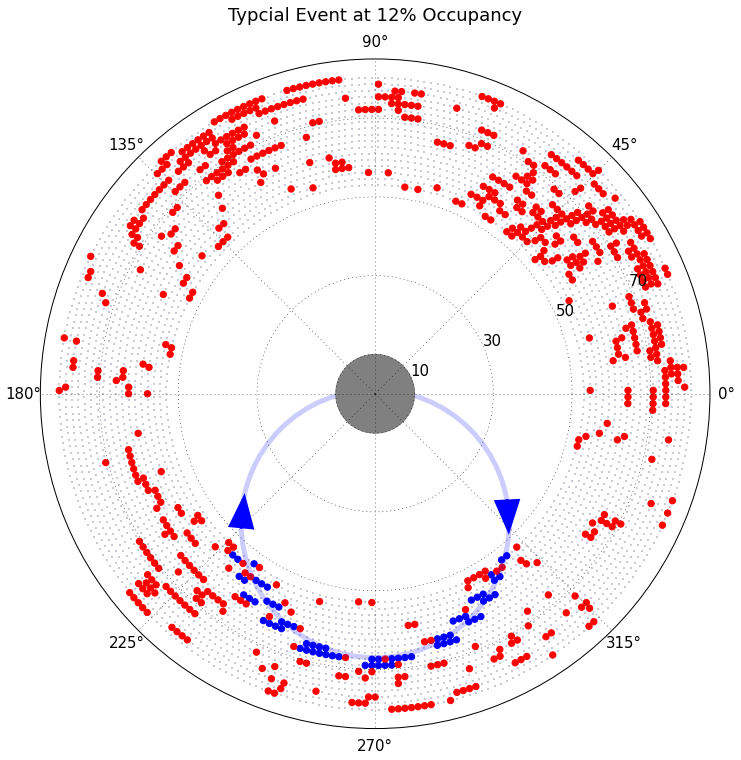

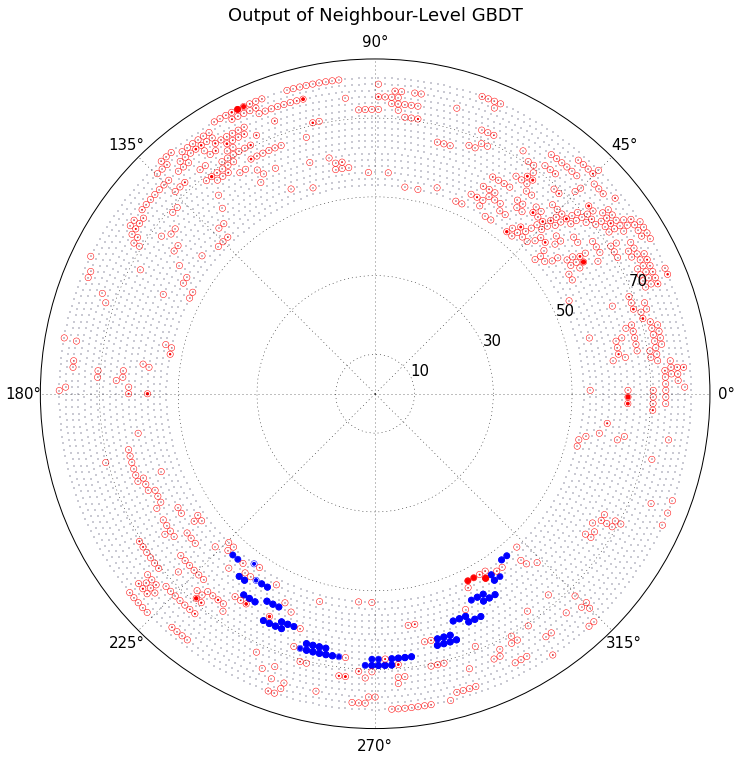

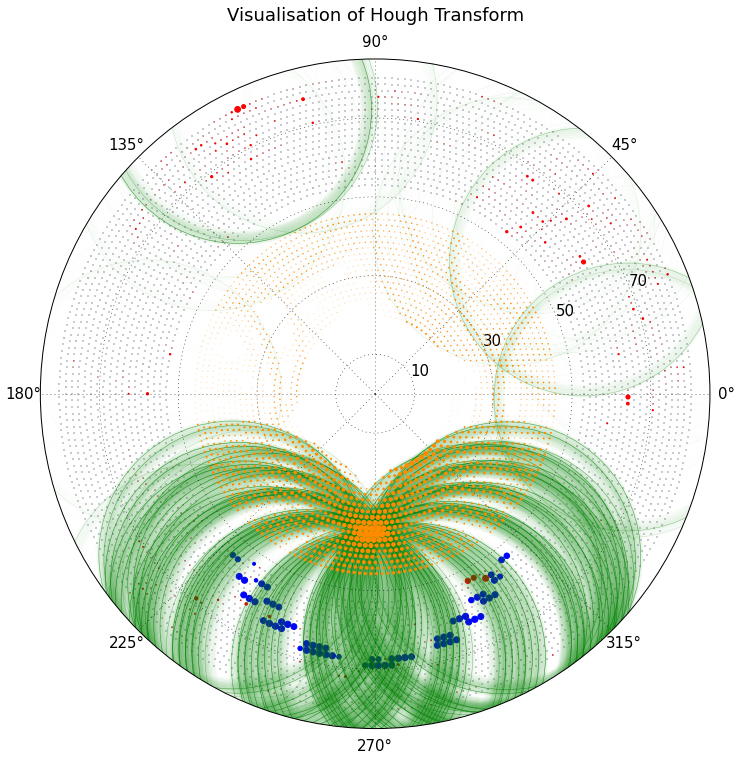

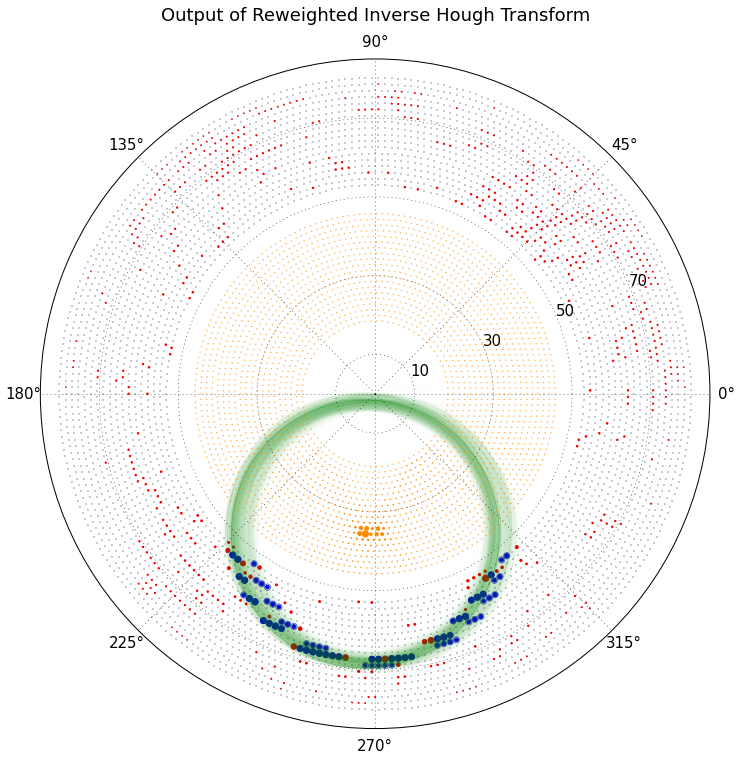

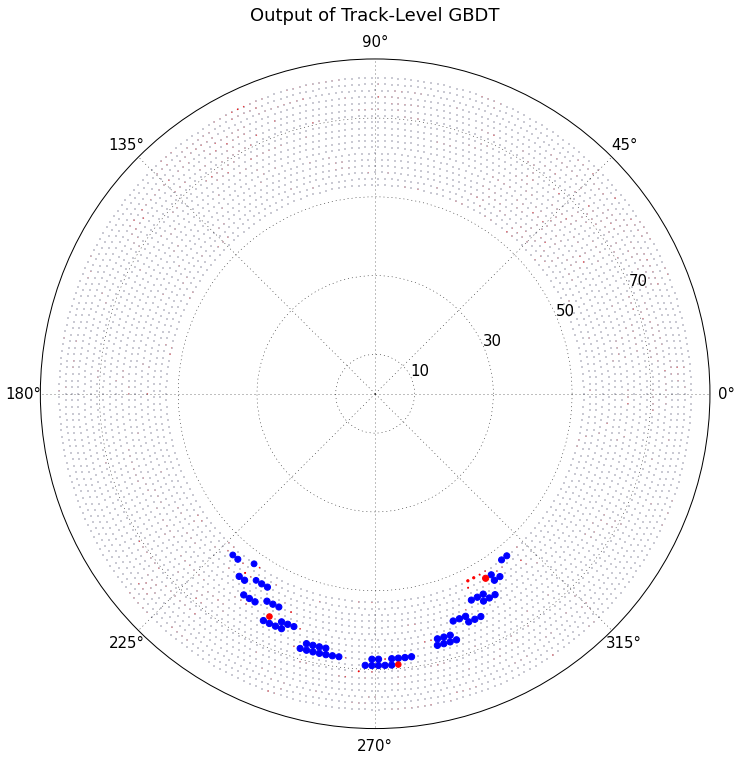

In [170]:
ax = draw_output(sig, bkg, bkg_color="black", sig_color="black")
this_title = ax.set_title("Input Hit Distribution to GBDT")
if save_fig:
    plt.savefig(save_dir+"algorithm_ex.png",  
               bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()
##########################################################################

ax = draw_output(sig, bkg)
this_title = ax.set_title("Typcial Event at 12% Occupancy")

target_spread = plt.Circle((0, -33), 34, transform=ax.transData._b, color="blue", 
                           fill=False, lw=5, alpha=0.2)
gca().add_artist(target_spread)

target_spread = plt.Circle((0, 0), 10, transform=ax.transData._b, color="grey")
gca().add_artist(target_spread)

arr = plt.arrow(-34, -34, 0.01, 0.1,  edgecolor = 'blue', facecolor = 'blue',lw=2, 
                transform=ax.transData._b, head_length=8, head_width=6) 
arr = plt.arrow(33.5, -27, 0.005, -0.1,  edgecolor = 'blue', facecolor = 'blue',lw=2, 
                transform=ax.transData._b, head_length=8, head_width=6) 
if save_fig:
    plt.savefig(save_dir+"algorithm_ex_0.png",  
                bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()

##########################################################################
ax = draw_output(sig, bkg, size=norm_size(first_gbdt))
add_outlines(sig, bkg)
this_title = ax.set_title("Output of Neighbour-Level GBDT")
if save_fig:
    plt.savefig(save_dir+"algorithm_ex_1.png",  
               bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()
##########################################################################
ax = draw_output(sig, bkg, size=norm_size(first_gbdt))
this_title = ax.set_title("Visualisation of Hough Transform")
for point in draw_points:
    add_transform(wire_xs[point], wire_ys[point], 34., 31.5, 34.5,  
               line_w =norm_size(first_gbdt,1)[point], 
               spread_w=norm_size(first_gbdt,0.10)[point])
add_tracks(draw_tracks_orig, norm_size(hough_image_evt,40), color="DarkOrange")
if save_fig:
    plt.savefig(save_dir+"algorithm_ex_2.png",  
               bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()
##########################################################################
ax = draw_output(sig, bkg, size=norm_size(norm_comb_hough(hough_even_3[event],hough_odd_3[event], 
                                                          normalize=False)))          
this_title = ax.set_title("Output of Reweighted Inverse Hough Transform")
for track in draw_tracks:
    add_transform(track_xs[track], track_ys[track], 34., 31.5, 34.5,  
               line_w=norm_size(hough_image,0.5)[track], 
               spread_w=norm_size(hough_image,0.15)[track])
add_tracks(draw_tracks, norm_size(hough_image), color="DarkOrange")
add_outlines(sig, [])
if save_fig:
    plt.savefig(save_dir+"algorithm_ex_3.png",  
               bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()
##########################################################################
ax = draw_output(sig, bkg, size=norm_size(second_gbdt))
this_title = ax.set_title("Output of Track-Level GBDT")
if save_fig:
    plt.savefig(save_dir+"algorithm_ex_4.png",  
               bbox_extra_artists=(this_title,), bbox_inches='tight')
plt.show()


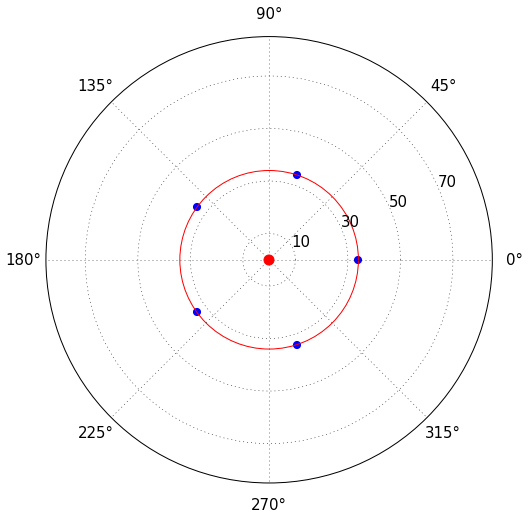

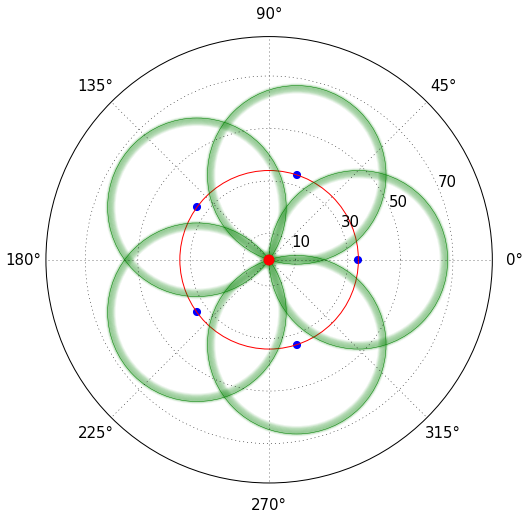

In [53]:
figsize(8,8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

matplotlib.rc('font', **font)

axes(polar=True)
# set appropriate
## Output with hough transform


samples = 6
radius = 34.


rho = radius*np.ones(samples)
theta = np.linspace(0,2*np.pi,samples)
#rho += 5*(np.random.rand(samples)-0.5)

rho = rho[:-1] 
theta = theta[:-1]
samples -= 1

for i in range(2):
    ax = plt.subplot(111, polar=True)
    ylim(0, 85)   
    ax.scatter(theta, rho, color="blue", s=50)
    ax.set_yticks(np.arange(10,81,20))
    add_circle(0,0,radius,color="red")
    ax.scatter(0, 0, color="Red",s=100, zorder=10)

    if i==1:
        for circ in range(samples):
            r = rho[circ]
            x = r*cos(theta[circ])
            y = r*sin(theta[circ])
            add_transform(x, y, radius, 31.5, 34.5, line_w=1., spread_w=0.15)
            #add_circle(x,y,radius,spread=2*smear)
    #plt.savefig("/home/elg112/COMET/Presentations/9month_review/images/hough_example_"+str(i+1)+".png", bbox_inches='tight')
    show()


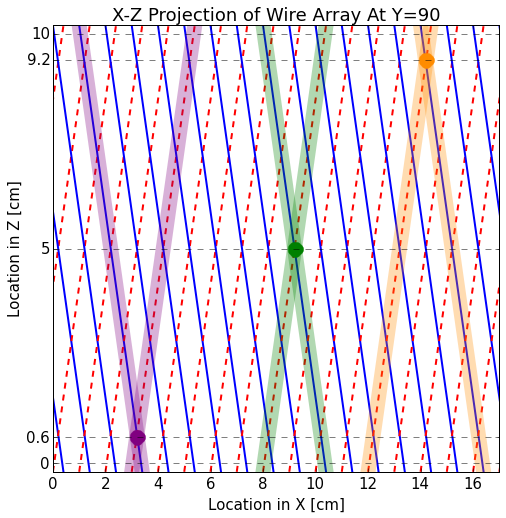

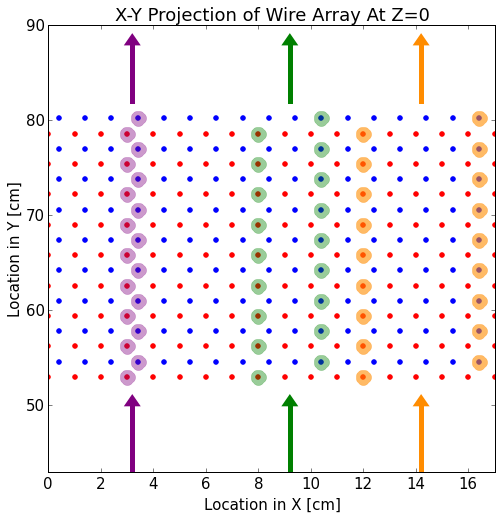

In [103]:
import matplotlib.lines as lines
ax = plt.subplot(111)

figsize(8,8)
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

#plt.axis('off')

angle = 2.4
room = 0.2
even_x, odd_x = [], []

for offset in range(40):
    offset -= 10
    ax.add_line(Line2D([offset,offset+angle], [0-room,10+room], lw=2, color='red', ls="--"))
    even_x.append(offset)
    ax.add_line(Line2D([offset+angle,offset], [0-room,10+room], lw=2, color='blue'))
    odd_x.append(offset+angle)

x_1 = 14
ax.plot(x_1+0.2, 9.4, color='DarkOrange',marker='.', markersize=30.0)
ax.add_line(Line2D([x_1-2,x_1-2+angle], [0-room,10.+room], lw=15, color='DarkOrange', alpha=0.3))
ax.add_line(Line2D([x_1+angle,x_1], [0-room,10+room], lw=15, color='DarkOrange', alpha=0.3))
    
x_2 = 8    
ax.plot(x_2+1.2, 5, 'g.', markersize=30.0)
ax.add_line(Line2D([x_2,x_2+angle], [0-room,10.+room], lw=15, color='green', alpha=0.3))
ax.add_line(Line2D([x_2+angle,x_2], [0-room,10+room], lw=15, color='green', alpha=0.3))

x_3 = 3
ax.plot(x_3 + 0.2, 0.6, '.', color='purple', markersize=30.0)
ax.add_line(Line2D([x_3,x_3+angle], [0-room,10+room], lw=15, color='purple', alpha=0.3))
ax.add_line(Line2D([x_3 - 2+angle,x_3-2], [0-room,10+room], lw=15, color='purple', alpha=0.3))


ax.set_xlim(0,17)
ax.set_xlabel("Location in X [cm]", fontsize=15)
ax.set_ylim(-room,10+room)
ax.set_yticks([0,0.6, 5,9.4,10])
ax.set_yticklabels(["0","0.6", "5","9.2","10"])
ax.grid(axis='y', color='black', alpha=1, ls='--')
ax.set_ylabel("Location in Z [cm]", fontsize=15)
ax.set_title("X-Z Projection of Wire Array At Y=90")
savefig(save_dir+"stereo_x_z.png", bbox_inches="tight")

ax.plot()
show()

ax = plt.subplot(111)
ax.set_ylim(43,90)
ax.set_xlim(0,17)
layers = np.arange(0,18)
layers += 0.046
even_layers = layers[::2]
odd_layers = layers[1::2] + 0.4

even_y = np.zeros(len(even_x)) +53
odd_y = np.zeros(len(even_x)) + 1.6 +53


for even_l, odd_l in zip(even_layers, odd_layers):
    ax.scatter(even_x, even_y, color="red")
    ax.scatter(odd_x, odd_y, color="blue")
    ax.plot(3, even_y[0], '.', color='purple', markersize=30.0, alpha=0.4)
    ax.plot(3.4, odd_y[0], '.', color='purple', markersize=30.0, alpha=0.4)
    ax.plot(8, even_y[0], '.', color='green', markersize=30.0, alpha=0.4)
    ax.plot(10.4, odd_y[0], '.', color='green', markersize=30.0, alpha=0.4)
    
    ax.plot(12, even_y[0], '.', color='DarkOrange', markersize=30.0, alpha=0.6)
    ax.plot(16.4, odd_y[0], '.', color='DarkOrange', markersize=30.0, alpha=0.6)
    
    even_y += 3.2
    odd_y += 3.2

ax.add_line(Line2D([14.2,14.2], [0,50], lw=5, color='DarkOrange'))
ax.add_line(Line2D([14.2,14.2], [82,88], lw=5, color='DarkOrange'))
arr = plt.arrow(14.2, 49, 0, 1,  edgecolor = 'DarkOrange', facecolor = 'DarkOrange',lw=2, 
           head_length=1, head_width=0.5) 
arr = plt.arrow(14.2, 87, 0, 1,  edgecolor = 'DarkOrange', facecolor = 'DarkOrange',lw=2, 
           head_length=1, head_width=0.5) 


ax.add_line(Line2D([9.2,9.2], [0,50], lw=5, color='green'))
ax.add_line(Line2D([9.2,9.2], [82,88], lw=5, color='green'))
arr = plt.arrow(9.2, 49, 0, 1,  edgecolor = 'green', facecolor = 'green',lw=2, 
           head_length=1, head_width=0.5) 
arr = plt.arrow(9.2, 87, 0, 1,  edgecolor = 'green', facecolor = 'green',lw=2, 
           head_length=1, head_width=0.5) 


ax.add_line(Line2D([3.2,3.2], [0,50], lw=5, color='purple'))
ax.add_line(Line2D([3.2,3.2], [82,88], lw=5, color='purple'))
arr = plt.arrow(3.2, 49, 0, 1,  edgecolor = 'purple', facecolor = 'purple',lw=2, 
           head_length=1, head_width=0.5) 
arr = plt.arrow(3.2, 87, 0, 1,  edgecolor = 'purple', facecolor = 'purple',lw=2, 
           head_length=1, head_width=0.5) 

#ax.add_line(Line2D([odd_l,odd_l], [7,10], lw=2, color='green'))
#ax.add_line(Line2D([12.1,12.1], [0,3], lw=2, color='purple'))
#ax.add_line(Line2D([12.1,12.1], [7,10], lw=2, color='purple'))
#ax.plot(8, 4, '.', color='purple', markersize=30.0, alpha=0.2)
#ax.plot(8.2, 6, '.', color='purple', markersize=30.0, alpha=0.2)
ax.set_xlabel("Location in X [cm]", fontsize=15)
ax.set_ylabel("Location in Y [cm]", fontsize=15)
ax.set_title("X-Y Projection of Wire Array At Z=0")
savefig(save_dir+"stereo_x_y.png", bbox_inches="tight")

ax.plot()
show()